In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
from glob import glob

import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow_addons.optimizers import AdamW
import tensorflow_probability as tfp

from PIL import Image

# https://arxiv.org/pdf/1711.00937.pdf

In [2]:
image_size = 64
batch_size = 64

directory = "../input/celeba-dataset/img_align_celeba/img_align_celeba/"

all_images = glob(directory + "*.jpg")
sampled_idx = np.random.choice(len(all_images), size=50000)
all_images = np.array(all_images)[sampled_idx]
border = int(len(all_images) * 0.9)
train_images = all_images[:border]
valid_images = all_images[border:]

In [3]:
def train_generator():
    for path in train_images:
        image = np.array(Image.open(path))
        yield tf.cast(image, dtype=tf.float32)
        
def valid_generator():
    for path in valid_images:
        image = np.array(Image.open(path))
        yield tf.cast(image, dtype=tf.float32)

In [49]:
def get_augmenter(image_size, uncropped_image_size=(image_size,image_size,3)):
    return keras.Sequential(
        [
            keras.Input(shape=uncropped_image_size),
            layers.Normalization(),
            layers.RandomFlip(mode="horizontal"),
            layers.RandomCrop(height=image_size, width=image_size),
        ],
        name="augmenter",
    )

def preprocess_image(data, crop_size=140):
    height = 218
    width = 178
    image = tf.image.crop_to_bounding_box(
        data,
        (height - crop_size) // 2,
        (width - crop_size) // 2,
        crop_size,
        crop_size,
    )
    image = tf.image.resize(image, size=[image_size, image_size], method="bicubic", antialias=True)
    return tf.clip_by_value(image / 255.0, 0.0, 1.0)


def prepare_dataset(generator):
    output_spec = tf.TensorSpec(shape=(218,178,3), dtype=tf.float32)
    return (
        tf.data.Dataset.from_generator(generator, output_signature=output_spec)
        .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
        .cache()
        .shuffle(10 * batch_size)
        .batch(batch_size, drop_remainder=True)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

train_dataset = prepare_dataset(train_generator)
val_dataset = prepare_dataset(valid_generator)

![image](https://i.imgur.com/R9VMWD6.png)

We define a latent embedding space $e ∈ R^{K×D}$ where $K$ is the size of the discrete latent space (i.e.,
a $K-way$ categorical), and $D$ is the dimensionality of each latent embedding vector $e_i$. Note that
there are $K$ embedding vectors $e_i ∈ R^D, i ∈ 1, 2, ..., K$. As shown in Figure, the model takes an
input $x$, that is passed through an encoder producing output $z_e(x)$. The discrete latent variables $z$
are then calculated by a nearest neighbour look-up using the shared embedding space $e$ as shown in
equation above. The input to the decoder is the corresponding embedding vector $e_k$ as given in equation 2.
One can see this forward computation pipeline as a regular autoencoder with a particular non-linearity
that maps the latents to 1-of-K embedding vectors. The complete set of parameters for the model are
union of parameters of the encoder, decoder, and the embedding space $e$.
The posterior categorical distribution $q(z|x)$ probabilities are defined as one-hot as follows:

See equation (1) in picture above

$z_e(x)$ is the output of the encoder network. 
The representation $z_e(x)$ is passed through the discretisation bottleneck followed by mapping onto
the nearest element of embedding $e$ as given in equations 1 and 2.
$z_q(x) = e_k$, where $k = argmin_j\lVert z_e(x) − e_j\rVert$ (2)

Note that there is no real gradient defined for equation 2, however we approximate the gradient
similar to the straight-through estimator and just copy gradients from decoder input $z_q(x)$ to
encoder output $z_e(x)$.

During forward computation the nearest embedding $z_q(x)$ (equation 2) is passed to the decoder, and
during the backwards pass the gradient $∇zL$ is passed unaltered to the encoder. Since the output
representation of the encoder and the input to the decoder share the same $D$ dimensional space,
the gradients contain useful information for how the encoder has to change its output to lower the
reconstruction loss.

In [5]:
class VectorQuantizer(layers.Layer):
    """ https://keras.io/examples/generative/vq_vae/ """
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super(VectorQuantizer, self).__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

        # keep between [0.25, 2]
        self.beta = beta

        # Initialize the embeddings which to quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name="embeddings_vqvae",
        )

    def call(self, x):
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        # Quantization.
        encoding_indices = self.get_code_indices(flattened)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)

        quantized = tf.reshape(quantized, input_shape)

        # Calculate vector quantization loss and add that to the layer
        commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)  # torch.detach()
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(self.beta * commitment_loss + codebook_loss)

        # Straight-through estimator.
        # During backpropagation, (quantized - x) won't be included in the computation graph and 
        # the gradients obtaind for quantized will be copied for inputs.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized

    def get_code_indices(self, flattened_inputs):
        # Calculate L2-normalized distance between the inputs and the codes.
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0) - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices

In [10]:
def get_encoder(latent_dim=128):
    encoder_inputs = keras.Input(shape=(image_size, image_size, 3))  # leaky_relu
    x = layers.Conv2D(32, 4, activation="relu", strides=2, padding="same")(
        encoder_inputs
    )
    x = layers.Conv2D(64, 4, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2D(128, 4, activation="relu", strides=2, padding="same")(x)
    
    encoder_outputs = layers.Conv2D(latent_dim, 1, padding="same")(x)
    return keras.Model(encoder_inputs, encoder_outputs, name="encoder")


def get_decoder(latent_dim=128):
    latent_inputs = keras.Input(shape=get_encoder(latent_dim).output.shape[1:])
    x = layers.Conv2DTranspose(128, 4, activation="relu", strides=2, padding="same")(
        latent_inputs
    )
    x = layers.Conv2DTranspose(64, 4, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(32, 4, activation="relu", strides=2, padding="same")(x)

    decoder_outputs = layers.Conv2DTranspose(3, 3, padding="same")(x)
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [12]:
def get_vqvae(latent_dim=128, num_embeddings=512):
    vq_layer = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")
    encoder = get_encoder(latent_dim)
    decoder = get_decoder(latent_dim)
    inputs = keras.Input(shape=(image_size, image_size, 3))
    encoder_outputs = encoder(inputs)
    quantized_latents = vq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    return keras.Model(inputs, reconstructions, name="vq_vae")


get_vqvae().summary()

Model: "vq_vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
encoder (Functional)         (None, 8, 8, 128)         182112    
_________________________________________________________________
vector_quantizer (VectorQuan (None, 8, 8, 128)         65536     
_________________________________________________________________
decoder (Functional)         (None, 64, 64, 3)         427075    
Total params: 674,723
Trainable params: 674,723
Non-trainable params: 0
_________________________________________________________________


In [18]:
class VQVAETrainer(keras.models.Model):
    def __init__(self, augmenter, latent_dim=128, num_embeddings=512, **kwargs):
        super(VQVAETrainer, self).__init__(**kwargs)
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings
        self.augmenter = augmenter
        self.train_mean = augmenter.layers[0].mean
        self.train_variance = augmenter.layers[0].variance

        self.vqvae = get_vqvae(self.latent_dim, self.num_embeddings)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss")
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]
    
    def denormalize(self, x):
        x = self.augmenter.layers[0].mean + (
            x * self.augmenter.layers[0].variance ** 0.5
        )
        return tf.clip_by_value(x, 0.0, 1.0)

    def train_step(self, x):
        x = x - self.train_mean
        
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.vqvae(x)

            # Calculate the losses.
            reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance
            )
            total_loss = reconstruction_loss + sum(self.vqvae.losses)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }
    
    def test_step(self, x):
        x = x - self.train_mean
        reconstructions = self.vqvae(x)
        
        reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance
            )
        total_loss = reconstruction_loss + sum(self.vqvae.losses)
        
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }
    
    def plot_images(self, epoch=None, logs=None, num_rows=3, num_cols=2):
        indices = np.random.randint(0, batch_size, size=num_rows*num_cols)
        test_images = tf.gather(next(iter(val_dataset)), indices.tolist(), axis=0) - self.train_mean
        preds = self.vqvae(test_images)
        
        for i in range(1, num_rows*num_cols+1, 2):
            plt.subplot(num_rows, num_cols, i)
            orig_image = test_images[i].numpy() + self.train_mean
            plt.imshow(orig_image[0])
            plt.title("Original")
            plt.axis("off")

            plt.subplot(num_rows, num_cols, i+1)
            recon_image = preds[i].numpy() + self.train_mean
            plt.imshow(recon_image[0])
            plt.title("Reconstructed")
            plt.axis("off")
            plt.tight_layout()
            plt.show()
            plt.close()

In [19]:
augmenter = get_augmenter(image_size)
augmenter.layers[0].adapt(train_dataset)

vqvae_trainer = VQVAETrainer(augmenter=augmenter)
vqvae_trainer.compile(optimizer=AdamW(learning_rate=0.001, weight_decay=1e-4))

callbacks = [
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", mode="min", patience=3),
        keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=5, restore_best_weights=True),
        keras.callbacks.LambdaCallback(on_epoch_end=vqvae_trainer.plot_images)
    ]

Epoch 1/30


2022-11-29 16:34:11.218528: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


703/703 [==============================] - 51s 62ms/step - loss: 33.9875 - reconstruction_loss: 0.2673 - vqvae_loss: 33.6094 - val_loss: 0.7152 - val_reconstruction_loss: 0.1776 - val_vqvae_loss: 0.5377


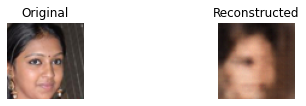

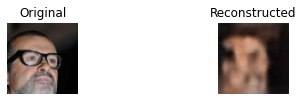

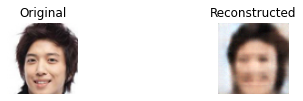

Epoch 2/30
703/703 [==============================] - 14s 19ms/step - loss: 0.5935 - reconstruction_loss: 0.1513 - vqvae_loss: 0.4313 - val_loss: 0.3756 - val_reconstruction_loss: 0.1352 - val_vqvae_loss: 0.2404


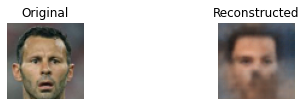

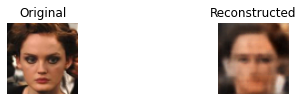

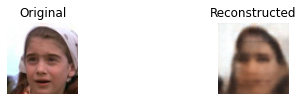

Epoch 3/30
703/703 [==============================] - 13s 19ms/step - loss: 0.3529 - reconstruction_loss: 0.1267 - vqvae_loss: 0.2230 - val_loss: 0.3173 - val_reconstruction_loss: 0.1217 - val_vqvae_loss: 0.1955


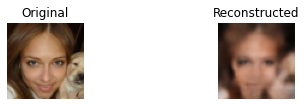

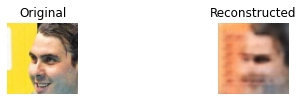

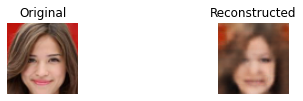

Epoch 4/30
703/703 [==============================] - 14s 20ms/step - loss: 0.3049 - reconstruction_loss: 0.1174 - vqvae_loss: 0.1857 - val_loss: 0.2881 - val_reconstruction_loss: 0.1156 - val_vqvae_loss: 0.1725


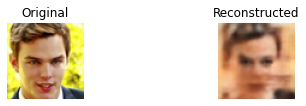

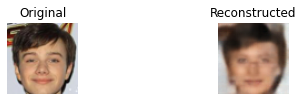

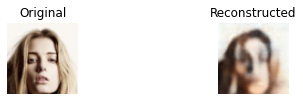

Epoch 5/30
703/703 [==============================] - 13s 19ms/step - loss: 0.2784 - reconstruction_loss: 0.1108 - vqvae_loss: 0.1663 - val_loss: 0.2682 - val_reconstruction_loss: 0.1094 - val_vqvae_loss: 0.1588


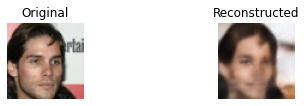

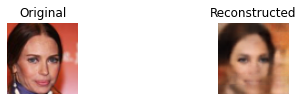

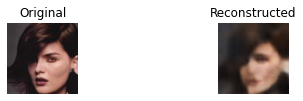

Epoch 6/30
703/703 [==============================] - 13s 19ms/step - loss: 0.2634 - reconstruction_loss: 0.1068 - vqvae_loss: 0.1558 - val_loss: 0.2643 - val_reconstruction_loss: 0.1059 - val_vqvae_loss: 0.1584


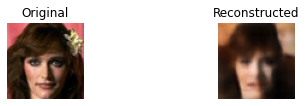

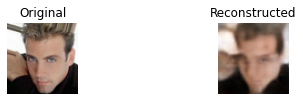

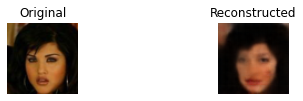

Epoch 7/30
703/703 [==============================] - 13s 19ms/step - loss: 0.2591 - reconstruction_loss: 0.1036 - vqvae_loss: 0.1550 - val_loss: 0.2636 - val_reconstruction_loss: 0.1028 - val_vqvae_loss: 0.1608


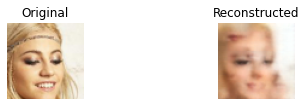

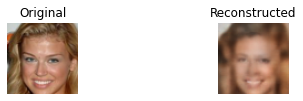

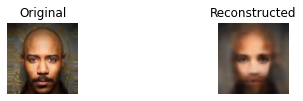

Epoch 8/30
703/703 [==============================] - 13s 19ms/step - loss: 0.2576 - reconstruction_loss: 0.1014 - vqvae_loss: 0.1557 - val_loss: 0.2578 - val_reconstruction_loss: 0.1013 - val_vqvae_loss: 0.1565


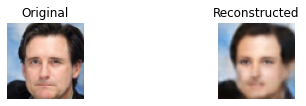

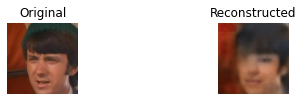

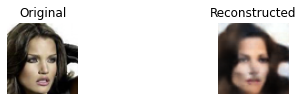

Epoch 9/30
703/703 [==============================] - 13s 19ms/step - loss: 0.2529 - reconstruction_loss: 0.0996 - vqvae_loss: 0.1529 - val_loss: 0.2501 - val_reconstruction_loss: 0.0987 - val_vqvae_loss: 0.1514


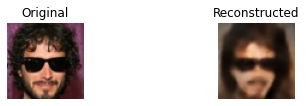

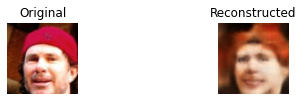

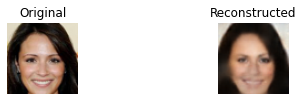

Epoch 10/30
703/703 [==============================] - 13s 19ms/step - loss: 0.2510 - reconstruction_loss: 0.0980 - vqvae_loss: 0.1529 - val_loss: 0.2543 - val_reconstruction_loss: 0.0979 - val_vqvae_loss: 0.1563


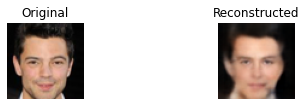

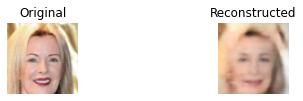

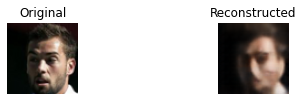

Epoch 11/30
703/703 [==============================] - 13s 19ms/step - loss: 0.2531 - reconstruction_loss: 0.0969 - vqvae_loss: 0.1561 - val_loss: 0.2561 - val_reconstruction_loss: 0.0970 - val_vqvae_loss: 0.1592


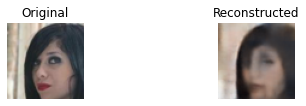

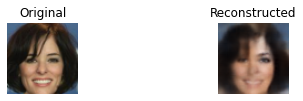

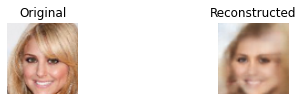

Epoch 12/30
703/703 [==============================] - 13s 19ms/step - loss: 0.2551 - reconstruction_loss: 0.0960 - vqvae_loss: 0.1588 - val_loss: 0.2563 - val_reconstruction_loss: 0.0991 - val_vqvae_loss: 0.1572


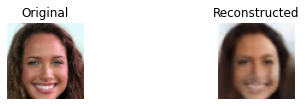

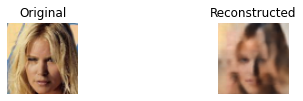

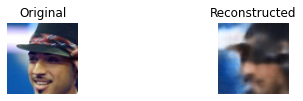

Epoch 13/30
703/703 [==============================] - 13s 19ms/step - loss: 0.2484 - reconstruction_loss: 0.0934 - vqvae_loss: 0.1547 - val_loss: 0.2462 - val_reconstruction_loss: 0.0944 - val_vqvae_loss: 0.1518


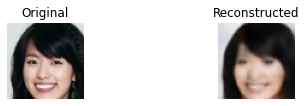

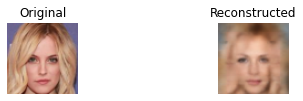

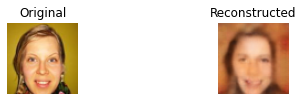

Epoch 14/30
703/703 [==============================] - 13s 19ms/step - loss: 0.2439 - reconstruction_loss: 0.0935 - vqvae_loss: 0.1505 - val_loss: 0.2464 - val_reconstruction_loss: 0.0948 - val_vqvae_loss: 0.1516


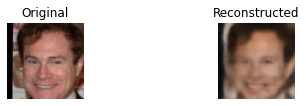

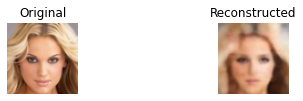

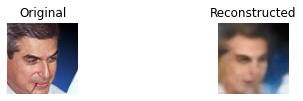

Epoch 15/30
703/703 [==============================] - 14s 19ms/step - loss: 0.2446 - reconstruction_loss: 0.0938 - vqvae_loss: 0.1509 - val_loss: 0.2479 - val_reconstruction_loss: 0.0950 - val_vqvae_loss: 0.1530


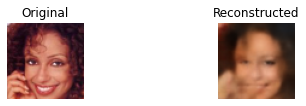

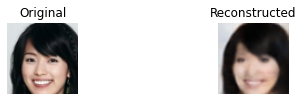

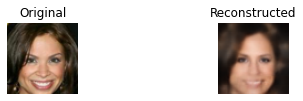

Epoch 16/30
703/703 [==============================] - 13s 19ms/step - loss: 0.2470 - reconstruction_loss: 0.0940 - vqvae_loss: 0.1530 - val_loss: 0.2512 - val_reconstruction_loss: 0.0952 - val_vqvae_loss: 0.1560


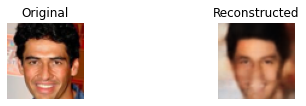

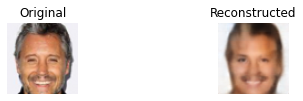

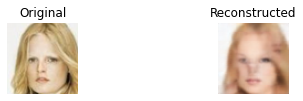

Epoch 17/30
703/703 [==============================] - 13s 19ms/step - loss: 0.2412 - reconstruction_loss: 0.0942 - vqvae_loss: 0.1472 - val_loss: 0.2355 - val_reconstruction_loss: 0.0961 - val_vqvae_loss: 0.1394


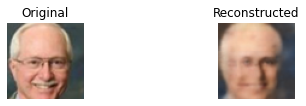

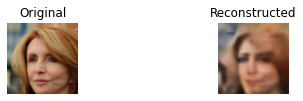

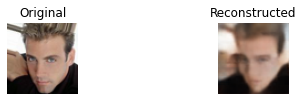

Epoch 18/30
703/703 [==============================] - 13s 19ms/step - loss: 0.2322 - reconstruction_loss: 0.0956 - vqvae_loss: 0.1370 - val_loss: 0.2355 - val_reconstruction_loss: 0.0975 - val_vqvae_loss: 0.1380


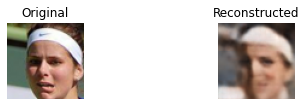

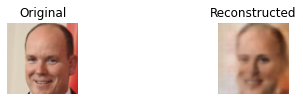

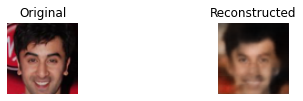

Epoch 19/30
703/703 [==============================] - 13s 19ms/step - loss: 0.2326 - reconstruction_loss: 0.0971 - vqvae_loss: 0.1360 - val_loss: 0.2394 - val_reconstruction_loss: 0.0991 - val_vqvae_loss: 0.1402


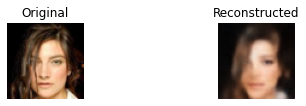

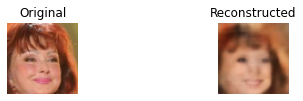

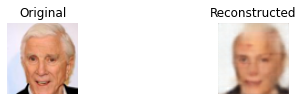

Epoch 20/30
703/703 [==============================] - 13s 19ms/step - loss: 0.2369 - reconstruction_loss: 0.0987 - vqvae_loss: 0.1386 - val_loss: 0.2465 - val_reconstruction_loss: 0.1009 - val_vqvae_loss: 0.1456


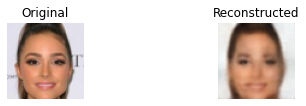

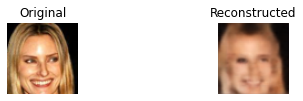

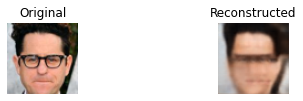

Epoch 21/30
703/703 [==============================] - 13s 19ms/step - loss: 0.2332 - reconstruction_loss: 0.1013 - vqvae_loss: 0.1327 - val_loss: 0.2168 - val_reconstruction_loss: 0.1042 - val_vqvae_loss: 0.1127


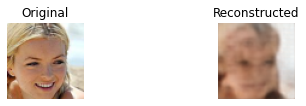

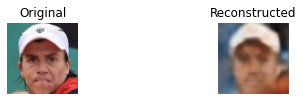

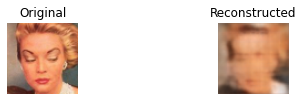

Epoch 22/30
703/703 [==============================] - 13s 19ms/step - loss: 0.2085 - reconstruction_loss: 0.1050 - vqvae_loss: 0.1046 - val_loss: 0.1983 - val_reconstruction_loss: 0.1081 - val_vqvae_loss: 0.0902


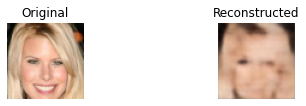

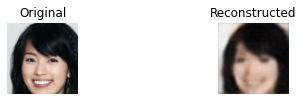

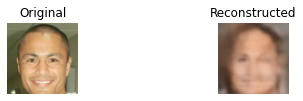

Epoch 23/30
703/703 [==============================] - 14s 19ms/step - loss: 0.1919 - reconstruction_loss: 0.1090 - vqvae_loss: 0.0840 - val_loss: 0.1859 - val_reconstruction_loss: 0.1124 - val_vqvae_loss: 0.0735


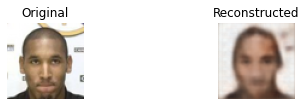

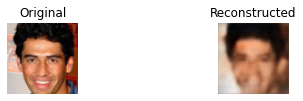

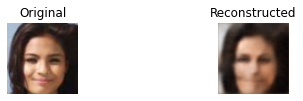

Epoch 24/30
703/703 [==============================] - 13s 19ms/step - loss: 0.1811 - reconstruction_loss: 0.1132 - vqvae_loss: 0.0689 - val_loss: 0.1775 - val_reconstruction_loss: 0.1167 - val_vqvae_loss: 0.0608


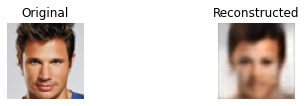

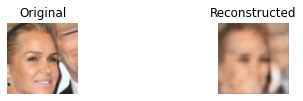

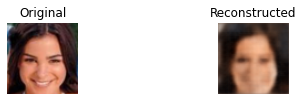

Epoch 25/30
703/703 [==============================] - 13s 19ms/step - loss: 0.1737 - reconstruction_loss: 0.1177 - vqvae_loss: 0.0573 - val_loss: 0.1726 - val_reconstruction_loss: 0.1213 - val_vqvae_loss: 0.0512


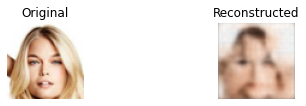

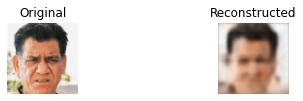

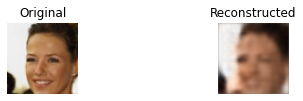

Epoch 26/30
703/703 [==============================] - 13s 19ms/step - loss: 0.1698 - reconstruction_loss: 0.1223 - vqvae_loss: 0.0487 - val_loss: 0.1703 - val_reconstruction_loss: 0.1262 - val_vqvae_loss: 0.0441


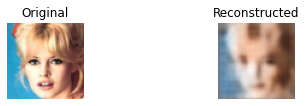

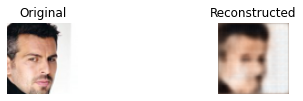

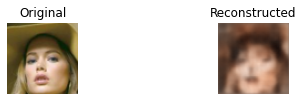

Epoch 27/30
703/703 [==============================] - 13s 18ms/step - loss: 0.1679 - reconstruction_loss: 0.1272 - vqvae_loss: 0.0420 - val_loss: 0.1695 - val_reconstruction_loss: 0.1312 - val_vqvae_loss: 0.0383


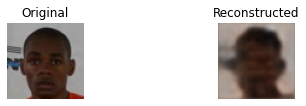

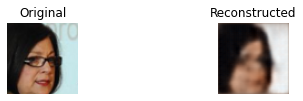

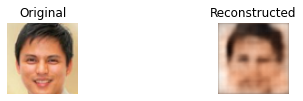

Epoch 28/30
703/703 [==============================] - 13s 19ms/step - loss: 0.1674 - reconstruction_loss: 0.1324 - vqvae_loss: 0.0365 - val_loss: 0.1701 - val_reconstruction_loss: 0.1366 - val_vqvae_loss: 0.0336


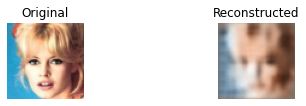

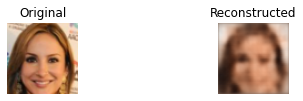

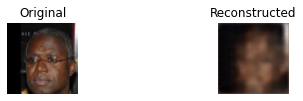

Epoch 29/30
703/703 [==============================] - 13s 19ms/step - loss: 0.1685 - reconstruction_loss: 0.1377 - vqvae_loss: 0.0322 - val_loss: 0.1720 - val_reconstruction_loss: 0.1420 - val_vqvae_loss: 0.0299


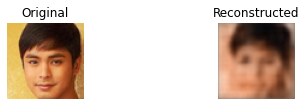

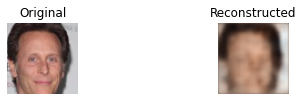

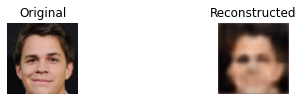

Epoch 30/30
703/703 [==============================] - 13s 19ms/step - loss: 0.1705 - reconstruction_loss: 0.1433 - vqvae_loss: 0.0288 - val_loss: 0.1748 - val_reconstruction_loss: 0.1478 - val_vqvae_loss: 0.0270


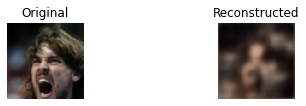

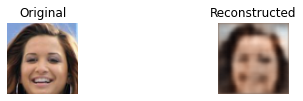

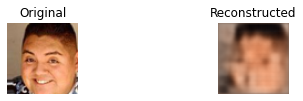

In [20]:
vqvae_trainer.fit(train_dataset, epochs=30, validation_data=val_dataset, callbacks=callbacks, verbose=1)

In [21]:
num_residual_blocks = 4
num_pixelcnn_layers = 4

encoder = vqvae_trainer.vqvae.get_layer("encoder")
quantizer = vqvae_trainer.vqvae.get_layer("vector_quantizer")

pixelcnn_input_shape = encoder.predict(np.random.randn(1,image_size,image_size,3)).shape[1:-1]
pixelcnn_input_shape

(8, 8)

In [60]:
class PixelConvLayer(layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super(PixelConvLayer, self).__init__()
        self.mask_type = mask_type
        self.conv = layers.Conv2D(**kwargs)

    def build(self, input_shape):
        # Build the conv2d layer to initialize kernel variables
        self.conv.build(input_shape)
        # Use the initialized kernel to create the mask
        kernel_shape = self.conv.kernel.get_shape()
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)

# residual block, but based on the PixelConvLayer.
class ResidualBlock(keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.conv1 = keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )
        self.pixel_conv = PixelConvLayer(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return keras.layers.add([inputs, x])


pixelcnn_inputs = keras.Input(shape=pixelcnn_input_shape, dtype=tf.int32)
ohe = tf.one_hot(pixelcnn_inputs, vqvae_trainer.num_embeddings)
x = PixelConvLayer(
    mask_type="A", filters=256, kernel_size=8, activation="relu", padding="same"  # 7, 8
)(ohe)

for _ in range(num_residual_blocks):
    x = ResidualBlock(filters=256)(x)

for _ in range(num_pixelcnn_layers):
    x = PixelConvLayer(
        mask_type="B",
        filters=256,
        kernel_size=1,
        strides=1,
        activation="relu",
        padding="valid",
    )(x)

out = keras.layers.Conv2D(
    filters=vqvae_trainer.num_embeddings, kernel_size=1, strides=1, padding="valid"
)(x)

pixel_cnn = keras.Model(pixelcnn_inputs, out, name="pixel_cnn")
pixel_cnn.summary()

Model: "pixel_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        [(None, 8, 8)]            0         
_________________________________________________________________
tf.one_hot_3 (TFOpLambda)    (None, 8, 8, 512)         0         
_________________________________________________________________
pixel_conv_layer_27 (PixelCo (None, 8, 8, 256)         8388864   
_________________________________________________________________
residual_block_12 (ResidualB (None, 8, 8, 256)         393856    
_________________________________________________________________
residual_block_13 (ResidualB (None, 8, 8, 256)         393856    
_________________________________________________________________
residual_block_14 (ResidualB (None, 8, 8, 256)         393856    
_________________________________________________________________
residual_block_15 (ResidualB (None, 8, 8, 256)         39

In [ ]:
# Generate the codebook indices.
data = train_dataset.map(lambda x: x - augmenter.layers[0].mean)

encoded_outputs = encoder.predict(data)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)

codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])
print(f"Shape of the training data for PixelCNN: {codebook_indices.shape}")

In [ ]:
pixel_cnn.compile(
    optimizer=AdamW(learning_rate=3e-4, weight_decay=3e-5),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

pixel_cnn.fit(
    x=codebook_indices,
    y=codebook_indices,
    epochs=10,
    validation_split=0.1,
)

Epoch 1/10
141/141 [==============================] - 6s 25ms/step - loss: 3.4079 - accuracy: 0.2194 - val_loss: 1.7043 - val_accuracy: 0.4900
Epoch 2/10
141/141 [==============================] - 2s 17ms/step - loss: 1.7720 - accuracy: 0.5243 - val_loss: 0.8785 - val_accuracy: 0.7333
Epoch 3/10
141/141 [==============================] - 2s 17ms/step - loss: 0.9230 - accuracy: 0.7504 - val_loss: 0.3000 - val_accuracy: 0.9021
Epoch 4/10
141/141 [==============================] - 2s 17ms/step - loss: 1.6359 - accuracy: 0.6773 - val_loss: 0.7984 - val_accuracy: 0.7583
Epoch 5/10
141/141 [==============================] - 2s 18ms/step - loss: 0.2017 - accuracy: 0.9424 - val_loss: 0.0772 - val_accuracy: 0.9769
Epoch 6/10
 25/141 [====>.........................] - ETA: 1s - loss: 0.0516 - accuracy: 0.9865

In [53]:
# Create a mini sampler model.
inputs = layers.Input(shape=pixel_cnn.input_shape[1:])
outputs = pixel_cnn(inputs, training=False)
categorical_layer = tfp.layers.DistributionLambda(tfp.distributions.Categorical)
outputs = categorical_layer(outputs)
sampler = keras.Model(inputs, outputs)

In [54]:
# Create an empty array of priors.
batch = 10
priors = np.zeros(shape=(batch,) + (pixel_cnn.input_shape)[1:])
batch, rows, cols = priors.shape

# Iterate over the priors because generation has to be done sequentially pixel by pixel.
for row in range(rows):
    for col in range(cols):
        # Feed the whole array and retrieving the pixel value probabilities for the next
        # pixel.
        probs = sampler.predict(priors)
        # Use the probabilities to pick pixel values and append the values to the priors.
        priors[:, row, col] = probs[:, row, col]

print(f"Prior shape: {priors.shape}")

Prior shape: (10, 8, 8)


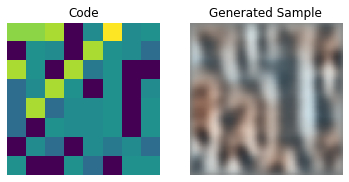

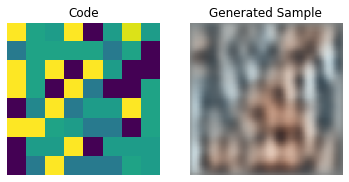

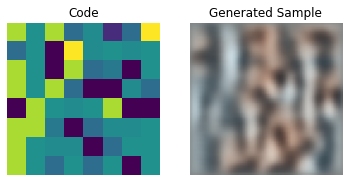

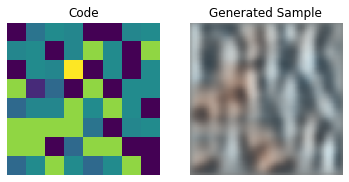

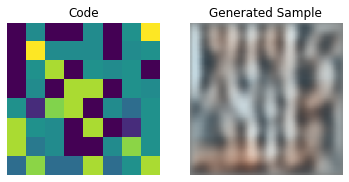

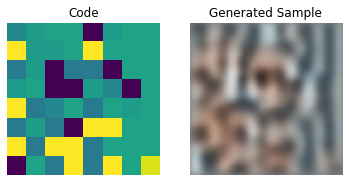

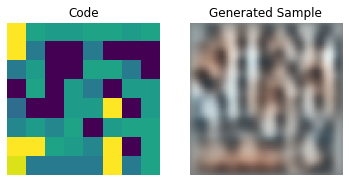

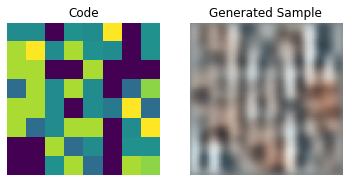

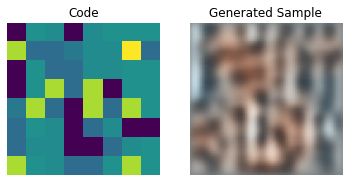

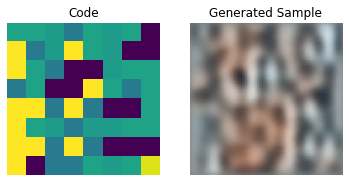

In [55]:
pretrained_embeddings = quantizer.embeddings
priors_ohe = tf.one_hot(priors.astype("int32"), vqvae_trainer.num_embeddings).numpy()
quantized = tf.matmul(
    priors_ohe.astype("float32"), pretrained_embeddings, transpose_b=True
)
quantized = tf.reshape(quantized, (-1, *(encoded_outputs.shape[1:])))

# Generate novel images.
decoder = vqvae_trainer.vqvae.get_layer("decoder")
generated_samples = decoder.predict(quantized)

for i in range(batch):
    plt.subplot(1, 2, 1)
    plt.imshow(priors[i])
    plt.title("Code")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(generated_samples[i].squeeze() + 0.5)
    plt.title("Generated Sample")
    plt.axis("off")
    plt.show()